In [2]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

/data/ephemeral/home/vm/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [27]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
filename = './configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco_aug1.py'
cfg = Config.fromfile(filename)

root='../../dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize
cfg.data.test.test_mode = True


cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/cascade_rcnn_r50_fpn_1x_coco_aug1'

# change number of classes
if('cascade' in filename):
    cfg.model.roi_head.bbox_head[0].num_classes=10
    cfg.model.roi_head.bbox_head[1].num_classes=10
    cfg.model.roi_head.bbox_head[2].num_classes=10
elif('retina' in filename
    or 'atss' in filename
    or 'detr' in filename):
    cfg.model.bbox_head.num_classes = 10
elif(filename in ['./configs/yolox/yolox_tiny_8x8_300e_coco.py']):
    cfg.model.bbox_head.feat_channels=10
elif(filename in ['./configs/yolo/yolov3_d53_320_273e_coco.py']):
    pass
else:
    cfg.model.roi_head.bbox_head.num_classes = 10


cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [28]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [29]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_latest.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: ./work_dirs/cascade_rcnn_r50_fpn_1x_coco_aug1/epoch_10.pth


In [30]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 6.1 task/s, elapsed: 800s, ETA:     0s

In [31]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.8082419 212.47632 689.1897 251.5665 734.35...,test/0000.jpg
1,0 0.5024223 758.2606 659.5775 907.5381 992.268...,test/0001.jpg
2,0 0.1680869 2.3150406 231.92755 137.57584 439....,test/0002.jpg
3,0 0.08110211 20.03421 0.0 996.2235 327.25262 0...,test/0003.jpg
4,0 0.37974954 423.1943 504.6265 501.97916 578.2...,test/0004.jpg


In [63]:
output

[[array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=

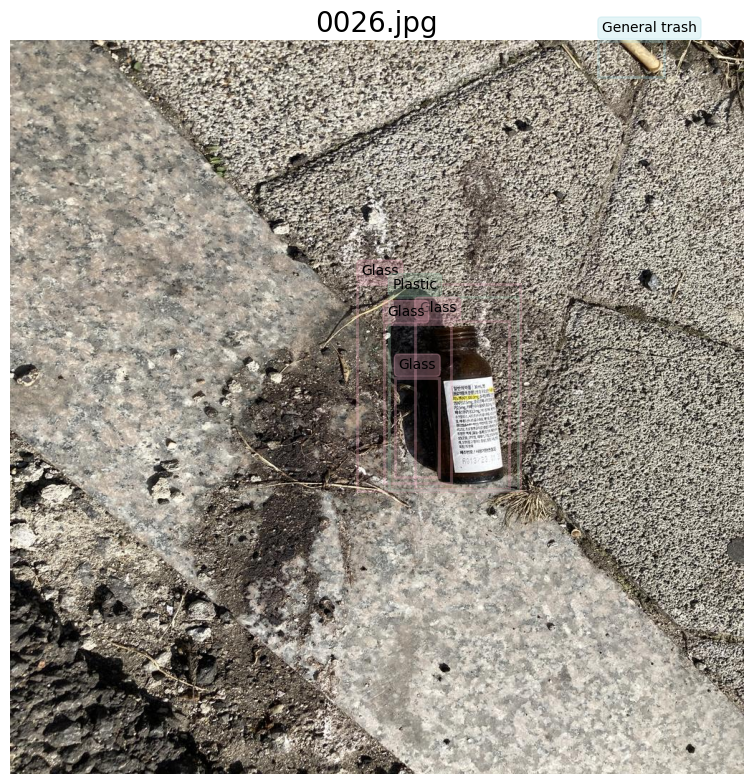

KeyboardInterrupt: Interrupted by user

In [33]:
import os
import json
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 12

COLOR_MAP = [
    (171, 222, 230), (203, 170, 203), (255, 255, 181), (255, 204, 182), (243, 176, 195),
    (151, 193, 169), (254, 225, 232), (198, 219, 218), (255, 150, 138), (85, 203, 205)
]
CATEGORIES = (
    "General trash", "Paper", "Paper pack", "Metal", "Glass", 
    "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
)

#output_dir 변경
output_dir = './work_dirs/cascade_rcnn_r50_fpn_1x_coco_aug1/submission_latest.csv'
data_dir = '/data/ephemeral/home/dataset'
start_num = 0


df = pd.read_csv(output_dir)

for i, bbox_info in enumerate(df.iloc[start_num:,0]):
    bbox_info = bbox_info.split()
    img_path = os.path.join(data_dir, df.iloc[i, 1])
    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots()
    for j in range(len(bbox_info))[::6]:    
        cat_id, pred, bbox = int(bbox_info[j]), float(bbox_info[j+1]), list(map(float, bbox_info[j+2:j+6]))
        cat_name = CATEGORIES[cat_id]
        color = [num/255 for num in COLOR_MAP[cat_id%10]]
        
        bbox_rect = patches.Rectangle(
            (bbox[0], bbox[1]), 
            (bbox[2]-bbox[0]), (bbox[3]-bbox[1]), 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none',
            alpha=0.3
        )
        ax.add_patch(bbox_rect)
        bbox_anno = plt.text(bbox[0]+5, bbox[1]-12, cat_name, fontsize=10)
        bbox_anno.set_bbox(dict(facecolor=color, alpha=0.3, boxstyle='round,pad=0.3', edgecolor=color))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1], fontsize=20)
    plt.tight_layout()
    plt.show()
    
    input()
    clear_output(wait=True)

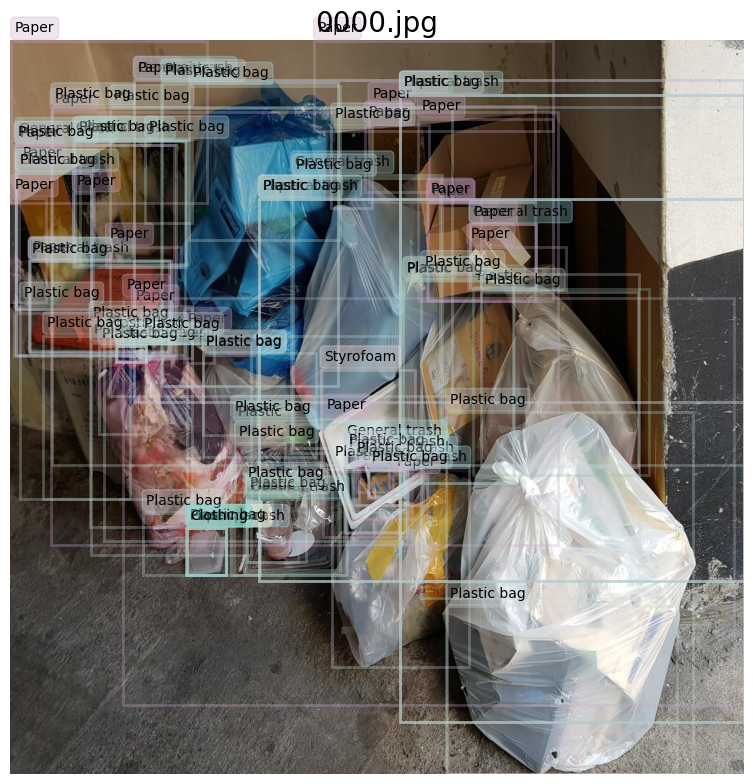

KeyboardInterrupt: Interrupted by user